In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, degree
from torch_geometric.nn import GCNConv
import pandas as pd
from torchmetrics.regression import R2Score
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt

<BarContainer object of 37 artists>

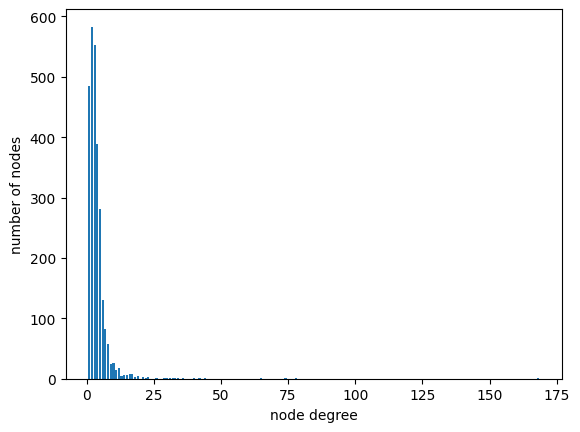

In [ ]:
dataset=Planetoid(root='E:/glass_git/ML-DL/Graph/data',name='Cora')
data=dataset[0]
degrees=degree(data.edge_index[0]).numpy()
numbers=Counter(degrees)

fix,ax=plt.subplots()
ax.set_xlabel('node degree')
ax.set_ylabel('number of nodes')
plt.bar(numbers.keys(), numbers.values())

''' 오른쪽 긴꼬리 분포인 경우 log10으로 정규화를 수행하여 정규분포로 근사화 한 후 학습시키면 성능이 더 좋아짐'''

In [ ]:
data.edge_index # 특정 노드의 이웃 수 

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [11]:
class GCN(nn.Module):
    def __init__(self,dim_in,dim_h,dim_out):
        super(GCN,self).__init__()
        self.gcn1=GCNConv(dim_in,dim_h)
        self.gcn2=GCNConv(dim_h,dim_out)
        self.acc = R2Score() 
        
    def forward(self, x, edge_index):
        h=self.gcn1(x,edge_index)
        h=torch.relu(h)
        h=self.gcn2(h,edge_index)
        return F.log_softmax(h,dim=1)
    
    def fit(self,data,epochs):
        criterion=nn.CrossEntropyLoss()
        optim=torch.optim.Adam(self.parameters(),lr=0.01, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optim.zero_grad()
            out=self(data.x,data.edge_index)
            loss=criterion(out[data.train_mask],data.y[data.train_mask])
            acc=self.acc(out[data.train_mask].argmax(dim=1),data.y[data.train_mask])
            loss.backward()
            optim.step()

            if epoch%20==0:
                val_loss=criterion(out[data.val_mask],data.y[data.val_mask])
                val_acc=self.acc(out[data.val_mask].argmax(dim=1),data.y[data.val_mask])
                print(f'epoch: {epoch}, train loss: {loss:.3f}, test loss: {val_loss:.3f}, train acc: {acc*100:.2f}, test acc: {val_acc*100:.2f}')

    @torch.no_grad()
    def test(self,data):
        self.eval()
        out=self(data.x,data.edge_index)        
        acc=self.acc(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [12]:
gcn=GCN(dataset.num_features, 16, dataset.num_classes)
gcn.fit(data,epochs=100)
acc=gcn.test(data)
print(f' GCN Test accuracy: {acc*100:.2f}')

epoch: 0, train loss: 1.941, test loss: 1.930, train acc: -70.00, test acc: -103.17
epoch: 20, train loss: 0.146, test loss: 0.798, train acc: 100.00, test acc: 19.60
epoch: 40, train loss: 0.019, test loss: 0.744, train acc: 100.00, test acc: 16.83
epoch: 60, train loss: 0.017, test loss: 0.717, train acc: 100.00, test acc: 16.45
epoch: 80, train loss: 0.019, test loss: 0.710, train acc: 100.00, test acc: 16.01
epoch: 100, train loss: 0.017, test loss: 0.712, train acc: 100.00, test acc: 12.19
 GCN Test accuracy: 38.95
